In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import the required libraries
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
#defining  important the attributes
IMAGE_SIZE=224
CHANNELS=3
BATCH_SIZE=32
EPOCHS=50
dataset = '/content/drive/MyDrive/destination/ds/augmented_dataset/'
# best_ResNet_epoch = '/content/drive/MyDrive/ResNet/best_epoch/'

In [5]:
# verify classes are balanced
def count_images(directory):
    image_count = 0
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        if os.path.isfile(img_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_count += 1
    return image_count

# Loop through each class (subdirectory) in the dataset directory
for subdir in os.listdir(dataset):
    class_dir = os.path.join(dataset, subdir)

    # Check if it's a directory
    if os.path.isdir(class_dir):
        # Count the number of images in this class directory
        image_count = count_images(class_dir)
        print(f"Class {subdir}: {image_count} images")
    else:
        print(f"{subdir} is not a directory.")

Class agricultural: 210 images
Class tenniscourt: 210 images
Class beach: 210 images
Class intersection: 210 images
Class mediumresidential: 210 images
Class parkinglot: 210 images
Class denseresidential: 210 images
Class forest: 210 images
Class mobilehomepark: 210 images
Class river: 210 images
Class buildings: 210 images
Class sparseresidential: 210 images
Class golfcourse: 210 images
Class overpass: 210 images
Class chaparral: 210 images
Class runway: 210 images
Class harbor: 210 images
Class freeway: 210 images
Class airplane: 210 images
Class storagetanks: 210 images
Class baseballdiamond: 210 images


In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/destination/ds/augmented_dataset/',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4410 files belonging to 21 classes.


In [7]:
landuse_class_names = dataset.class_names
landuse_class_names

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(224, 224, 3)


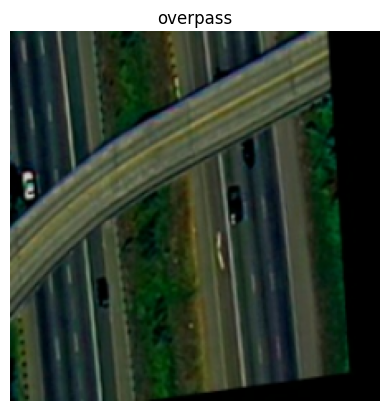

In [9]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(landuse_class_names[label_batch[0]])
    plt.axis("off")

In [10]:
# Extract class names from the dataset
class_names = dataset.class_names

# Prepare to display one image per class
plt.figure(figsize=(15, 15))

# Dictionary to store the first image path per class
class_first_image_paths = {}

# Iterate over the dataset to find and display the first image from each class
for images, labels in dataset:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]  # Get the class name from the label
        if class_name not in class_first_image_paths:
            # Store the path of the first image encountered for this class
            class_first_image_paths[class_name] = image
            # Display the first image found for this class
            plt.subplot(5, 5, len(class_first_image_paths))  # Adjust subplot position dynamically
            plt.imshow(image.numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")

        # Break loop if we have found one image per class
        if len(class_first_image_paths) == len(class_names):
            break

    # Break outer loop if we have found one image per class
    if len(class_first_image_paths) == len(class_names):
        break

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [11]:
# function to split DS
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2 ,test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_data_s = ds.take(train_size)
    val_data_s = ds.skip(train_size).take(val_size)
    test_data_s = ds.skip(train_size).skip(val_size)

    return train_data_s, val_data_s, test_data_s

train_data_s, val_data_s, test_data_s = get_dataset_partitions_tf(dataset)

In [12]:
len(train_data_s)

96

In [13]:
len(val_data_s)

27

In [14]:
len(test_data_s)

15

In [15]:
train_data_s = train_data_s.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_s = val_data_s.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_s = test_data_s.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
     layers.experimental.preprocessing.Rescaling(1.0/255)
]
)

**VGG19 ARCHITECTURE**

In [20]:
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras import layers, models

# # Define input shape and number of classes
# input_shape = (224, 224, 3)  # Image size: 224x224 pixels with 3 color channels (RGB)
# num_classes = 21  # Assuming you have 21 classes for your specific task

# # Load pre-trained VGG19 model
# pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# # Freeze convolutional layers
# for layer in pretrained_model.layers:
#     layer.trainable = False

# # Add custom dense layers for your task
# x = pretrained_model.output
# x = layers.Flatten()(x)
# x = layers.Dense(4096, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(4096, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# predictions = layers.Dense(num_classes, activation='softmax')(x)

# # Create a new model
# model = models.Model(inputs=pretrained_model.input, outputs=predictions)

# # Print model summary
# model.summary()


from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models

# Define input shape and number of classes
input_shape = (224, 224, 3)  # Image size: 224x224 pixels with 3 color channels (RGB)
num_classes = 21  # Assuming you have 21 classes for your specific task

# Load pre-trained VGG19 model
pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze convolutional layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Add custom dense layers for your task
x = pretrained_model.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)  # Reduced units
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)   # Reduced units
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Create a new model
model = models.Model(inputs=pretrained_model.input, outputs=predictions)

# Print model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_data_s,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_data_s
)

Epoch 1/50
96/96 [==============================] - 23s 222ms/step - loss: 16.5075 - accuracy: 0.3783 - val_loss: 1.1953 - val_accuracy: 0.8067
Epoch 2/50
96/96 [==============================] - 22s 227ms/step - loss: 5.1308 - accuracy: 0.6256 - val_loss: 0.6175 - val_accuracy: 0.8715
Epoch 3/50
96/96 [==============================] - 21s 215ms/step - loss: 4.2582 - accuracy: 0.7003 - val_loss: 0.3603 - val_accuracy: 0.9201
Epoch 4/50
96/96 [==============================] - 20s 211ms/step - loss: 3.6534 - accuracy: 0.7524 - val_loss: 0.4424 - val_accuracy: 0.9236
Epoch 5/50
96/96 [==============================] - 21s 215ms/step - loss: 2.9607 - accuracy: 0.8007 - val_loss: 0.4024 - val_accuracy: 0.9340
Epoch 6/50
96/96 [==============================] - 21s 218ms/step - loss: 2.7984 - accuracy: 0.8160 - val_loss: 0.3128 - val_accuracy: 0.9491
Epoch 7/50
96/96 [==============================] - 21s 224ms/step - loss: 2.4629 - accuracy: 0.8542 - val_loss: 0.3124 - val_accuracy: 0.944

In [23]:
import datetime

currentDT = datetime.datetime.now()
print(currentDT);
model_version="VGG19-V1"
model.save(f"/content/drive/MyDrive/VGG19/versions/{model_version}")

2024-04-28 16:24:13.733974


In [25]:
scores = model.evaluate(test_data_s)
scores

15/15 [==============================] - 3s 170ms/step - loss: 0.9565 - accuracy: 0.9688


[0.956480085849762, 0.96875]

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 96}

In [28]:
history.history['accuracy']

[0.3783431053161621,
 0.6255707740783691,
 0.7002609372138977,
 0.752446174621582,
 0.8007175326347351,
 0.816046953201294,
 0.854207456111908,
 0.8659490942955017,
 0.8962817788124084,
 0.8809523582458496,
 0.9018265008926392,
 0.9008480310440063,
 0.9161774516105652,
 0.9093281030654907,
 0.9272667765617371,
 0.9184605479240417,
 0.9207436442375183,
 0.9099804162979126,
 0.9331376552581787,
 0.9204174876213074,
 0.9279190897941589,
 0.9344422817230225,
 0.942270040512085,
 0.9409654140472412,
 0.93705153465271,
 0.9363992214202881,
 0.9341161251068115,
 0.946183979511261,
 0.9406392574310303,
 0.9468362927436829,
 0.9474886059761047,
 0.9478147625923157,
 0.9549902081489563,
 0.9575994610786438,
 0.9553163647651672,
 0.9595564007759094,
 0.9520547986030579,
 0.9585779309272766,
 0.9569471478462219,
 0.9540117383003235,
 0.9536855816841125,
 0.9562948346138,
 0.9598825573921204,
 0.9536855816841125,
 0.9624918699264526,
 0.9579256176948547,
 0.9598825573921204,
 0.9670580625534058,
 0

In [29]:
acc=history.history['accuracy']
vali_acc=history.history['val_accuracy']
loss=history.history['loss']
vali_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

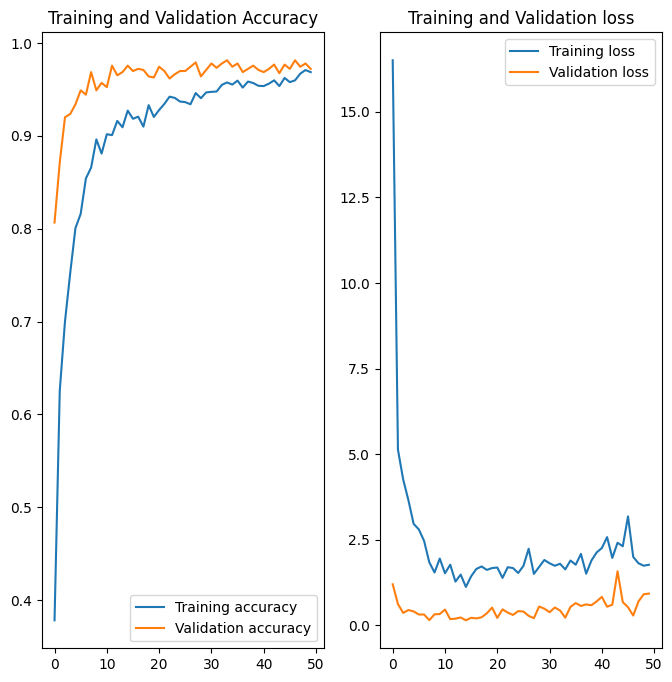

In [31]:
EPOCHS=50
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), vali_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), vali_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

first image to predict
actual label:  baseballdiamond
1/1 [==============================] - 0s 32ms/step
predicted label: baseballdiamond


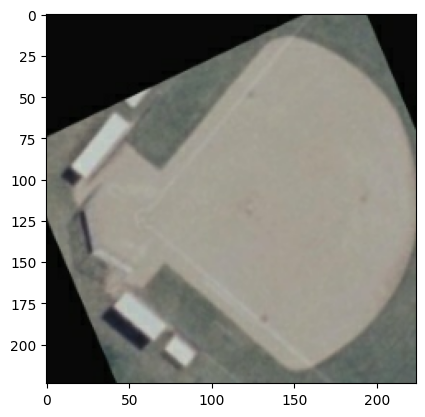

In [34]:
for images_batch, labels_batch in test_data_s.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label= labels_batch [0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    print("actual label: ",landuse_class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:",landuse_class_names[numpy.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions=model.predict(img_array)

    predicted_class= landuse_class_names[numpy.argmax(predictions[0])]
    confidence = round(100*(numpy.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


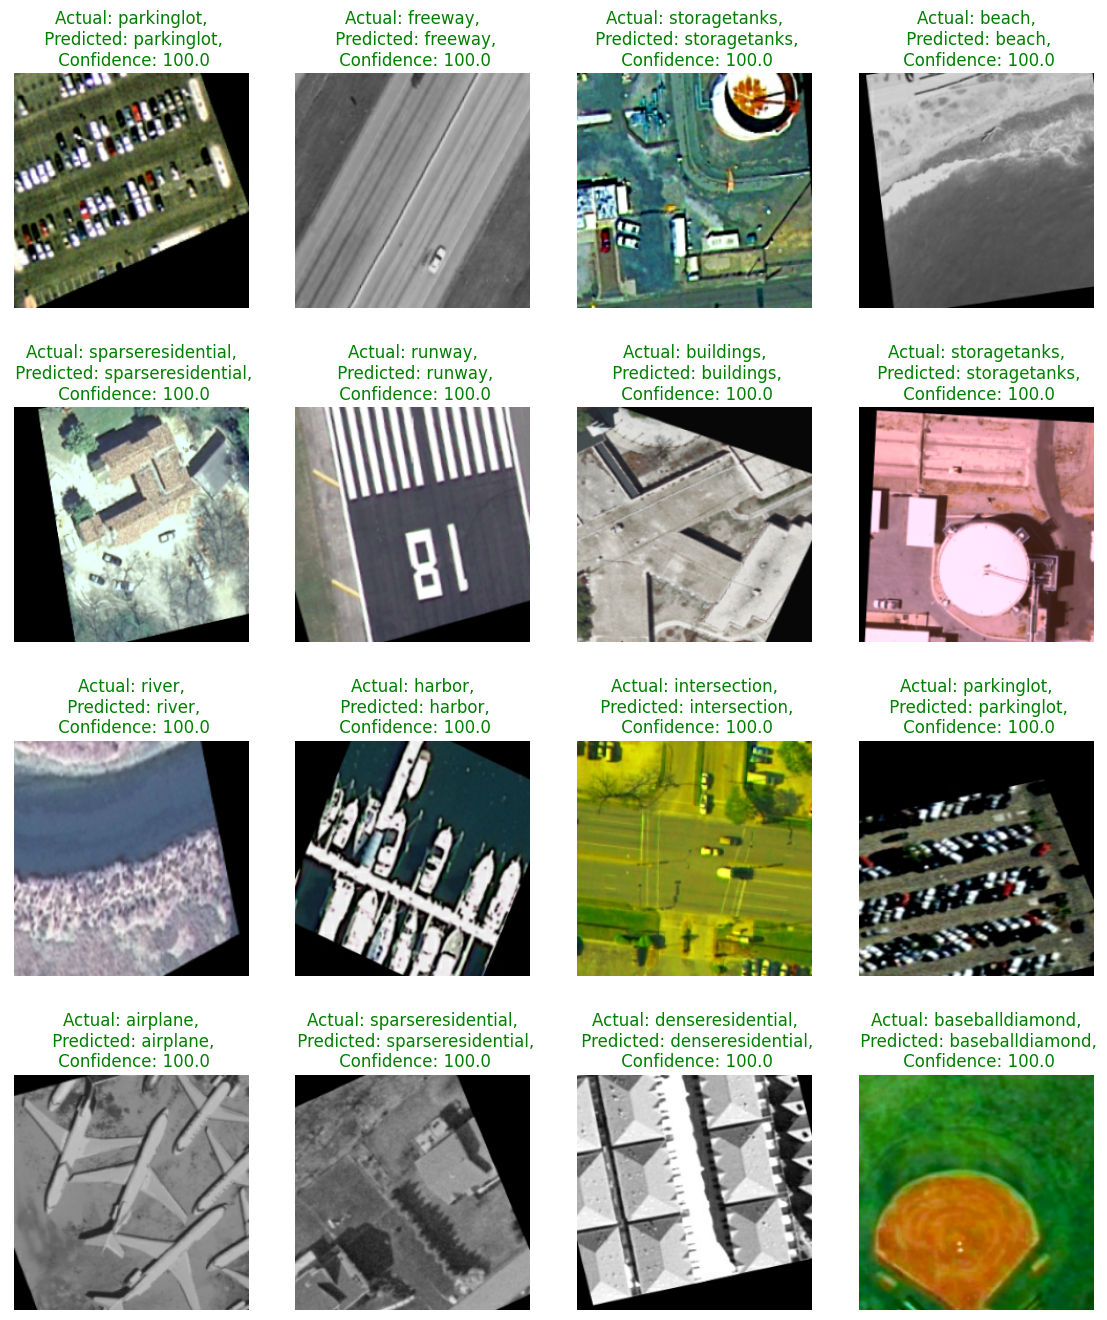

In [36]:
plt.figure(figsize=(16, 16))
for images, labels in test_data_s.take(1):

    for i in range(16) :

        ax = plt.subplot(4, 4, i+1)
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class= landuse_class_names[labels[i]]

        # plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        if actual_class == predicted_class:
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}", color='green')
        else:
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}", color='red')

        plt.axis("off")

In [37]:
!pip install seaborn

1/1 [==============================] - 0s 17ms/step


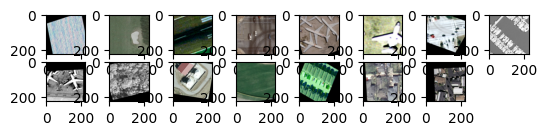

In [38]:
y_pred = []
y_true = []
for images, labels in test_data_s:

    for i in range(len(test_data_s)) :

        ax = plt.subplot(8, 8, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class=landuse_class_names[labels[i]]
        y_pred.append(predicted_class)
        y_true.append(actual_class)

In [39]:
y_true

['chaparral',
 'mobilehomepark',
 'tenniscourt',
 'river',
 'agricultural',
 'beach',
 'tenniscourt',
 'harbor',
 'chaparral',
 'mediumresidential',
 'baseballdiamond',
 'baseballdiamond',
 'agricultural',
 'runway',
 'buildings',
 'tenniscourt',
 'chaparral',
 'chaparral',
 'sparseresidential',
 'golfcourse',
 'baseballdiamond',
 'intersection',
 'harbor',
 'freeway',
 'airplane',
 'overpass',
 'river',
 'buildings',
 'runway',
 'mediumresidential',
 'baseballdiamond',
 'intersection',
 'harbor',
 'storagetanks',
 'baseballdiamond',
 'beach',
 'freeway',
 'beach',
 'denseresidential',
 'buildings',
 'forest',
 'sparseresidential',
 'denseresidential',
 'baseballdiamond',
 'sparseresidential',
 'parkinglot',
 'freeway',
 'storagetanks',
 'beach',
 'sparseresidential',
 'runway',
 'buildings',
 'storagetanks',
 'river',
 'harbor',
 'intersection',
 'parkinglot',
 'airplane',
 'sparseresidential',
 'denseresidential',
 'overpass',
 'mediumresidential',
 'intersection',
 'airplane',
 'for

In [40]:
y_pred

['chaparral',
 'mobilehomepark',
 'tenniscourt',
 'river',
 'agricultural',
 'beach',
 'tenniscourt',
 'harbor',
 'chaparral',
 'airplane',
 'baseballdiamond',
 'baseballdiamond',
 'agricultural',
 'runway',
 'mediumresidential',
 'tenniscourt',
 'chaparral',
 'chaparral',
 'sparseresidential',
 'golfcourse',
 'river',
 'intersection',
 'harbor',
 'freeway',
 'airplane',
 'overpass',
 'river',
 'buildings',
 'runway',
 'mediumresidential',
 'baseballdiamond',
 'intersection',
 'harbor',
 'storagetanks',
 'baseballdiamond',
 'beach',
 'freeway',
 'beach',
 'denseresidential',
 'buildings',
 'forest',
 'sparseresidential',
 'denseresidential',
 'baseballdiamond',
 'sparseresidential',
 'parkinglot',
 'freeway',
 'storagetanks',
 'beach',
 'sparseresidential',
 'runway',
 'buildings',
 'storagetanks',
 'river',
 'harbor',
 'intersection',
 'parkinglot',
 'airplane',
 'sparseresidential',
 'denseresidential',
 'overpass',
 'mediumresidential',
 'intersection',
 'airplane',
 'forest',
 'int

Text(50.72222222222221, 0.5, 'True labels')

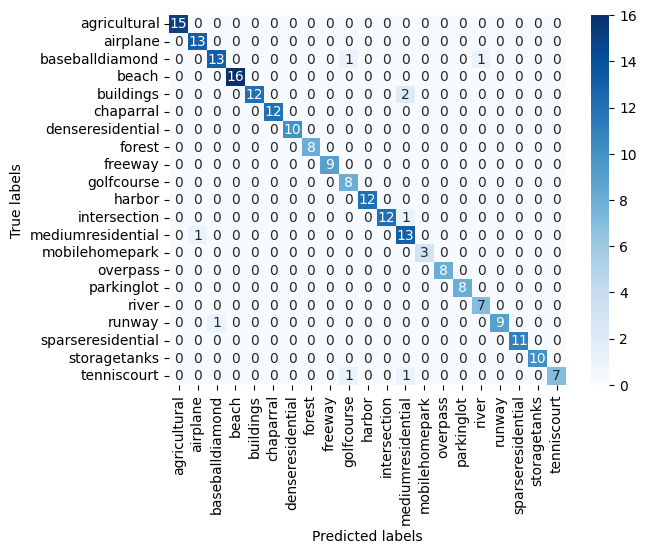

In [41]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# assume y_true and y_pred are the true labels and predicted labels, respectively
cm = confusion_matrix(y_true, y_pred)

# define class names
landuse_class_names =['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']
# create heatmap with labeled axes
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# set labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')


In [42]:
cm

array([[15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0, 13,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0],
       [ 0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,
         0,  0,  0,

In [43]:
num_classes = 21  # classes
precision = []
recall = []

for i in range(num_classes):
    tp = cm[i, i]  # True positives for class i
    fp = sum(cm[:, i]) - tp  # False positives for class i
    fn = sum(cm[i, :]) - tp  # False negatives for class i

    # Calculate precision (p) and recall (r) for class i
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0  # Handle division by zero
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Handle division by zero

    # Append precision and recall to respective lists
    precision.append(p)
    recall.append(r)

print("Precision:", precision)
print("Recall:", recall)


Precision: [1.0, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.7647058823529411, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0]
Recall: [1.0, 1.0, 0.8666666666666667, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9230769230769231, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.7777777777777778]


In [44]:
# calculate precision and recall for each class
num_classes = 4
precision = []
recall = []
for i in range(num_classes):
    tp = cm[i, i]
    fp = sum(cm[:, i]) - tp
    fn = sum(cm[i, :]) - tp
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    precision.append(p)
    recall.append(r)

print("Precision:", precision)
print("Recall:", recall)


Precision: [1.0, 0.9285714285714286, 0.9285714285714286, 1.0]
Recall: [1.0, 1.0, 0.8666666666666667, 1.0]


In [45]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')


In [46]:
from sklearn.metrics import classification_report

# get the classification report, which includes F1 score for each class
report = classification_report(y_true, y_pred)

# print the classification report
print(report)


                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        15
         airplane       0.93      1.00      0.96        13
  baseballdiamond       0.93      0.87      0.90        15
            beach       1.00      1.00      1.00        16
        buildings       1.00      0.86      0.92        14
        chaparral       1.00      1.00      1.00        12
 denseresidential       1.00      1.00      1.00        10
           forest       1.00      1.00      1.00         8
          freeway       1.00      1.00      1.00         9
       golfcourse       0.80      1.00      0.89         8
           harbor       1.00      1.00      1.00        12
     intersection       1.00      0.92      0.96        13
mediumresidential       0.76      0.93      0.84        14
   mobilehomepark       1.00      1.00      1.00         3
         overpass       1.00      1.00      1.00         8
       parkinglot       1.00      1.00      1.00       

**SAVING MODEL**

In [47]:
import os
from tensorflow.keras.models import load_model

# Assuming 'model' is your Keras model object
save_path = '/content/drive/MyDrive/VGG19/models/VGG19.h5'
model.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**EXPLAINABILITY FOR LIME**

In [48]:
! pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=2457b177290d4106adf6ffd75aa60588bdadcb5297d5dca0c3314862ac8eeb8c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


**sample IMG for lime**

first image to predict
actual label:  chaparral
1/1 [==============================] - 0s 62ms/step
predicted label: chaparral


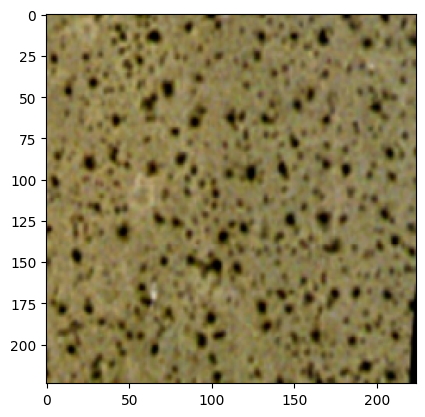

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


for images_batch, labels_batch in test_data_s.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label= labels_batch [0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    print("actual label: ",landuse_class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:",landuse_class_names[np.argmax(batch_prediction[0])])





  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
Top labels for test image:
5
20
9
Explanation for top label:


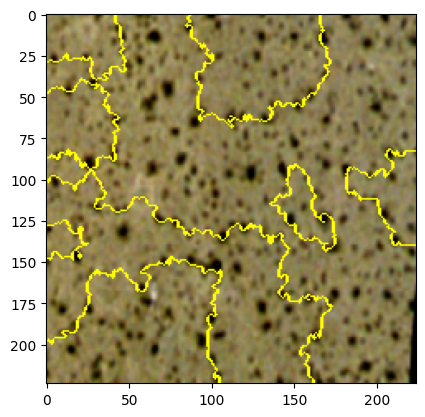

In [50]:
import lime
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Assuming you have a 'first_image' variable containing your test image
# Generate the LIME explanation
explainer = lime_image.LimeImageExplainer()

# Define a predict_proba function for your model
def predict_proba(images):
    # Make predictions with your model
    preds = model.predict(images)
    # Return the predicted probabilities
    return preds

# Define a function to explain an instance
def my_explain_instance(image):
    # Generate an explanation for the test image
    explanation = explainer.explain_instance(
        image,
        predict_proba,
        top_labels=3,
        num_samples=1000,
        labels=list(range(21))  # Adjust labels based on your 21 classes
    )
    return explanation

# Generate an explanation for the test image
explanation = my_explain_instance(first_image)

# Show the top labels for the test image
print('Top labels for test image:')
for label in explanation.top_labels:
    print(label)

# Show the explanation for the top label
print('Explanation for top label:')
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Use the top label
    positive_only=True,
    num_features=15,
    hide_rest=False
)

# Overlay the explanation mask on the original image
plt.imshow(mark_boundaries(first_image, mask))
plt.show()


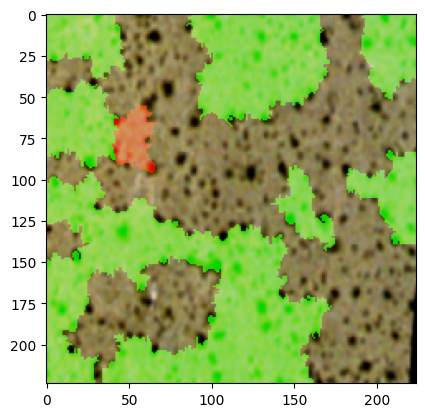

In [51]:
# Visualize the resulting explanation
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Get the image and explanation as numpy arrays
image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.imshow(image)

**SHAPLEY ADDIDITIVE EXPLAINABLILITY**

In [52]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.4 MB/s eta 0:00:00


In [53]:
import matplotlib.pyplot as plt
import tensorflow as tf

def get_image_for_prediction(dataset, class_names, image_size=(224, 224)):
    # Get the first image and label from the dataset
    for images_batch, labels_batch in dataset.take(1):
        first_image = images_batch[0].numpy().astype('uint8')
        first_label = labels_batch[0].numpy()

        # Display the image and print the actual label
        plt.imshow(first_image)
        plt.show()
        print("Actual label:", landuse_class_names[first_label])

        # Preprocess the image for model input
        image = tf.image.convert_image_dtype(first_image, tf.float32)
        image = tf.image.resize_with_pad(image, target_height=image_size[0], target_width=image_size[1])
        image = tf.expand_dims(image, axis=0)  # Add batch dimension

        return image



In [55]:
import matplotlib.pyplot as plt
import numpy as np

landuse_class_names = dataset.class_names

images_array = []  # Array to store the images

for images_batch, labels_batch in test_data_s.take(1):
    for i in range(20):  # Modify the range to specify the number of images you want
        image = images_batch[i].numpy().astype('uint8')
        label = labels_batch[i].numpy()

        print("Image to predict:", i+1)
        plt.imshow(image)
        plt.show()

        print("Actual label:", landuse_class_names[label])
        batch_prediction = model.predict(np.expand_dims(images_batch[i], axis=0))
        predicted_label = landuse_class_names[np.argmax(batch_prediction)]

        print("Predicted label:", predicted_label)
        images_array.append(image)

# 20 images in array


Output hidden; open in https://colab.research.google.com to view.

**explainer**

In [56]:
import shap
shap.initjs()
print(first_image.shape)
masker = shap.maskers.Image("inpaint_telea", first_image.shape)

explainer = shap.Explainer(model, masker, output_names=landuse_class_names)

explainer

(224, 224, 3)


In [57]:
# Convert the list of images to a numpy array
images_array = np.array(images_array)

shap_values = explainer(images_array, outputs=shap.Explanation.argsort.flip[:6])

shap_values.shape
shap.image_plot(shap_values)


Output hidden; open in https://colab.research.google.com to view.

In [58]:
!pip install tensorflow matplotlib
!pip install gradcam
!pip install tf-explain


ERROR: Could not find a version that satisfies the requirement gradcam (from versions: none)
ERROR: No matching distribution found for gradcam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00


First image to predict


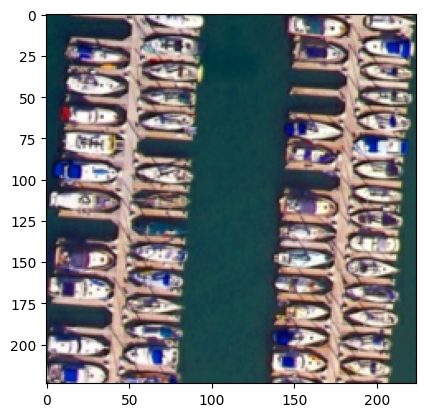

Actual label: harbor
1/1 [==============================] - 0s 54ms/step
Predicted label: harbor


In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined your test dataset as test_data_s

# Get the first image and label from the test dataset
for images_batch, labels_batch in test_data_s.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    plt.show()

    print("Actual label:", landuse_class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", landuse_class_names[np.argmax(batch_prediction[0])])

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    predicted_class = landuse_class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

# Assuming you have defined Disease_class_names elsewhere


In [68]:
from tf_explain.core.grad_cam import GradCAM
import tensorflow as tf

# model = tf.keras.models.load_model('path_to_your_model.h5')

# Load a sample image (or
img = tf.keras.preprocessing.image.img_to_array(first_image)
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=first_label, layer_name="block5_conv4")  # 281 is the tabby cat index in ImageNet

# Save the visualization
explainer.save(grid, ".", "grad_cam.png")

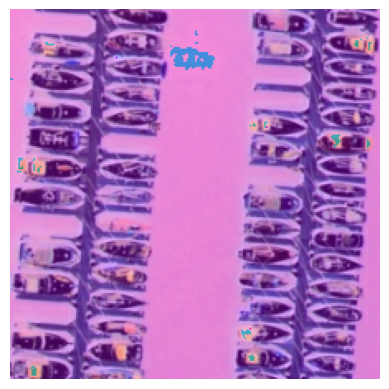

In [69]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace 'image_path' with the path to your saved GradCAM visualization image
image_path = "grad_cam.png"

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()
